##### Тояков А. О.
##### М8о-407б-18

Целью работы является исследование свойств некоторых динамических нейронных сетей,алгоритмов обучения, а также применение сетей в задачах аппроксимации функций и распознавания динамических образов.

In [4]:
! pip3 install --upgrade --user scikit-learn==1.0.1

Python 3.6.9


In [6]:
import neurolab as nl
import numpy as np
import numpy.matlib
from sklearn.metrics import mean_squared_error
import pyrenn
from matplotlib import pyplot as plt
import math
import neurolab as nl
import random
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from sklearn.neural_network import MLPRegressor
from fireTS.models import NARX

AttributeError: module 'google.protobuf.internal.containers' has no attribute 'MutableMapping'

Вариант №26:

1) 05/1814

2) $u(k) = cos(k^2) - cos(k)$

3) $g(k) = \sin{(k^2 - 10k + 3)}, \; \forall k \in [2.5, 4.84], \;$ $R = [1, 2, 3]$

In [3]:
date = "1814-05-01"
a = 2.5
b = 4.84
R = [1, 2, 3] # delays

def g(k):
    return np.sin(k**2 - 10 * k + 3)

def u(k):
    return np.cos(k**2) - np.cos(k)

def f(k):
    y = [0.]
    for i in k:
        y.append(y[-1] / (1 + y[-1]**2) + u(i)**3)
    return y[:-1]

### Описание

#### Focused Time-Delay Neural Network, FTDNN

Сеть прямого распространения с запаздыванием похожа на адаптивный фильтратор, однако имеет 2 полносвязанных слоя вместо одного, что делает ее более гибкой.

![title](./1.jpg)

Такая система позволяет успешно справляться с задачами, связанными с динамическими процессами, такими как распознование звукового или видео потока.

#### Distributed Time-Delay Neural Network, TDNN

В отличие от FTDNN сеть прямого распространения с распределенным запаздыванием имеет TDL блок не только перед первым слоем, н и перед вторым.

![title](./2.jpg)

#### Non-linearAutoRegressive network with eXogeneous inputs, NARX

Нелинейная авторегрессионная сеть с внешними входами отличается от базовой FTDNN тем, что выход первого слоя формируется не только из перемножения матрицы весов на входные значения, но и из перемножения другой матрицы весов с выходом TDL блока, сформированного из предыдущих выходов нейронной сети.

![title](./3.jpg)

Такая структура дает сети адаптироваться не только за счет известных значений текущего момента, но и предсказанных сетью до этого, что позволяет ей справляться с управлением динамическими системами, где требуется адаптация.

### Задание №1

Построить и обучить сеть прямого распространения с запаздыванием (Focused Time-DelayNeural Network, FTDNN), которая будет аппроксимировать последовательность чисел Вольфа, а также выполнить многошаговый прогноз.

Формируем входные данные:

In [4]:
df = pd.read_csv('wolfie.csv', sep=';', header=None)
df.head()

,0,1,2,3,4,5,6,7
0,1818,1,1,1818.001,-1,-1.0,0,1
1,1818,1,2,1818.004,-1,-1.0,0,1
2,1818,1,3,1818.007,-1,-1.0,0,1
3,1818,1,4,1818.010,-1,-1.0,0,1
4,1818,1,5,1818.012,-1,-1.0,0,1


In [5]:
df = df.iloc[:, 0:4]
df.drop([2], axis=1, inplace=True)

df[0] = df[0].astype(str)
df[1] = df[1].astype(str)
df.index = pd.to_datetime(df[0] + '-' + df[1])

df.drop([0], axis=1, inplace=True)
df.drop([1], axis=1, inplace=True)

df.head()

,3
1818-01-01,1818.001
1818-01-01,1818.004
1818-01-01,1818.007
1818-01-01,1818.010
1818-01-01,1818.012


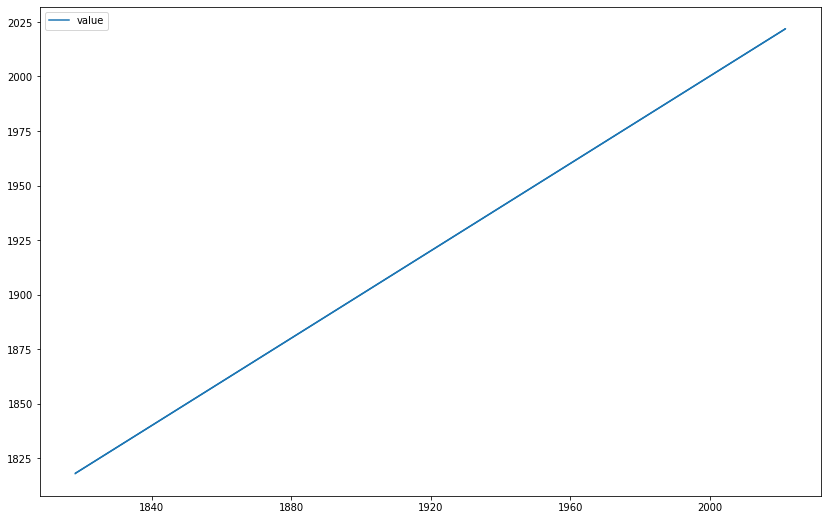

In [6]:
plt.figure(figsize=(14, 9))
plt.plot(df, label="value")
plt.legend()
plt.show()

In [7]:
values = df.values.flatten()

Усредняющий фильтр smooth с заданной шириной окна:

In [8]:
def smooth(a, windowWidth):
    out0 = np.convolve(a, np.ones(windowWidth, dtype=int), 'valid') / windowWidth    
    r = np.arange(1, windowWidth-1,2)
    start = np.cumsum(a[:(windowWidth-1)-1])[::2] / r
    stop = (np.cumsum(a[:-(windowWidth-1):-1])[::2] / r)[::-1]
    return np.concatenate((start, out0, stop))

Зададим ширину окна и сгладим данные:

In [9]:
widthWindow = 12
smoothValues = smooth(values, widthWindow)

Обновим данные в датафрейме на сглаженные и зададим начало в соответствии с вариантом.

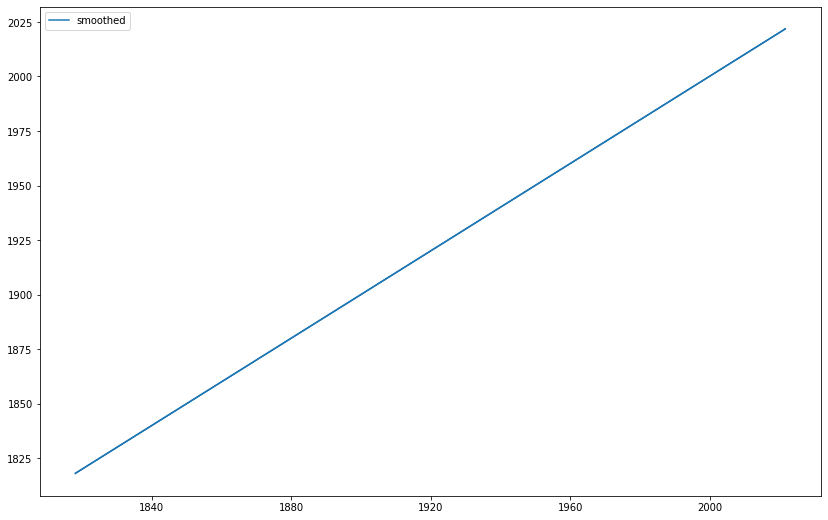

In [10]:
shift = df.values.size - smoothValues.size
df.iloc[shift:] = smoothValues[:, np.newaxis]

df = df[df.index >= pd.to_datetime(date)]

plt.figure(figsize=(14, 9))
plt.plot(df, label="smoothed")
plt.legend()
plt.show()

Сформируем обучающее множество (сразу с задержками) и тестовое множество для многошагового прогноза.

In [11]:
deep = 5

In [12]:
trainSize = int(len(df) * 0.7)
train = df[:trainSize]
test = df[trainSize:]

trainData = train.values.squeeze()
xTrain = np.array([trainData[i:i + deep] for i in range(len(trainData) - deep)])
yTrain = train.iloc[deep:].values

testData = test.values.squeeze()
xTest = np.array([testData[i:i + deep] for i in range(len(testData) - deep)])
yTest = test.iloc[deep:].values

Создадим и обучим нейронную сеть:

In [13]:
model = Sequential()
model.add(Dense(12, input_dim=deep, activation='tanh'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(xTrain, yTrain, epochs=60, batch_size=2, verbose=0)

NameError: name 'Sequential' is not defined

Выход сети:

In [14]:
predictTrain = model.predict(xTrain)

MSE = mean_squared_error(yTrain, predictTrain)
print('MSE = {}'.format(MSE))
print('RMSE = {}'.format(np.sqrt(MSE)))

NameError: name 'model' is not defined

NameError: name 'predictTrain' is not defined

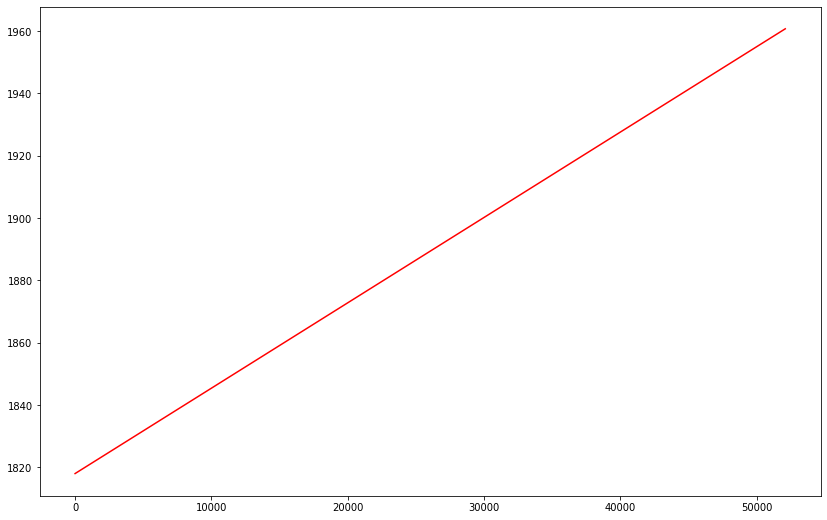

In [15]:
plt.figure(figsize=(14, 9))

plt.plot(yTrain, color='red')
plt.plot(predictTrain, color='blue')

plt.legend(['Train values', 'Network values'])
plt.title("Demonstration")
plt.show()

In [16]:
predictTest = model.predict(xTest)

MSE = mean_squared_error(yTest, predictTest)
print('MSE = {}'.format(MSE))
print('RMSE = {}'.format(np.sqrt(MSE)))

NameError: name 'model' is not defined

NameError: name 'predictTest' is not defined

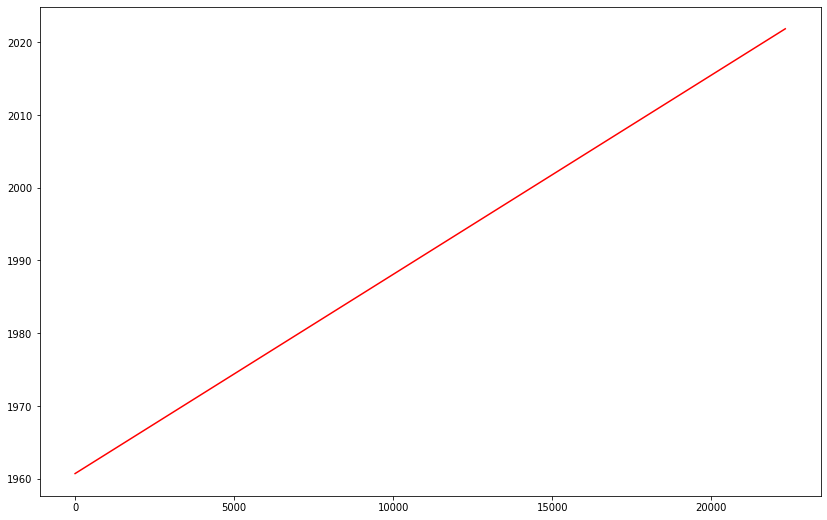

In [17]:
plt.figure(figsize=(14, 9))

plt.plot(yTest, color='red')
plt.plot(predictTest, color='green')

plt.legend(['Test values', 'Network values'])
plt.title("Demonstration")
plt.show()

### Задание №2

Построить и обучить сеть прямого распространения с распределенным запаздыванием (Distributed Time-Delay Neural Network, TDNN), которая будет выполнять распознавание динамического образа.

Сгенерируем набор из точек:

In [18]:
p1_k = np.linspace(0, 1, int(1 / 0.025), endpoint=True)
p2_k = np.linspace(a, b, int((b - a) / 0.025), endpoint=True)

p1 = np.sin(4 * np.pi * p1_k) # main signal
p2 = g(p2_k) # signal to detect

t1 = np.ones(len(p1_k)) * (-1)
t2 = np.ones(len(p2_k))

p2 = p2.reshape(1, -1)
t2 = t2.reshape(1, -1)

In [19]:
P = np.concatenate((numpy.matlib.repmat(p1, 1, R[0]), p2,
                    numpy.matlib.repmat(p1, 1, R[1]), p2,
                    numpy.matlib.repmat(p1, 1, R[2]), p2), axis=1).reshape(-1, 1)

T = np.concatenate((numpy.matlib.repmat(t1, 1, R[0]), t2,
                    numpy.matlib.repmat(t1, 1, R[1]), t2,
                    numpy.matlib.repmat(t1, 1, R[2]), t2), axis=1).reshape(-1, 1)

T = T.ravel() # makes 1-D array
P = P.ravel()

Создадим и обучим сеть с задержками, равными $5$:

In [20]:
nn = pyrenn.CreateNN([1, 8, 1], dIn=[5], dIntern=[5])

nn = pyrenn.train_LM(P, T, nn, E_stop=1e-5, k_max=100)

Maximum number of iterations reached


Выход сети:

In [21]:
output = pyrenn.NNOut(P, nn)

In [ ]:
plt.figure(figsize=(14, 9))
plt.plot(T, color='red')
plt.plot(output)
plt.legend(['Train target', 'Network output'])
plt.show()

In [23]:
output[output >= 0] = 1.0
output[output < 0] = -1.0

MSE = mean_squared_error(T.reshape(T.shape[0]), output)
print('MSE = {}'.format(MSE))
print('RMSE = {}'.format(np.sqrt(MSE)))

MSE = 0.05394990366088632
RMSE = 0.23227118560184412


Для проверки качества распознавания сформируем новое обучающее множество, изменив одно из значений $R$.

In [24]:
P2 = np.concatenate((numpy.matlib.repmat(p1, 1, R[0]), p2,
                    numpy.matlib.repmat(p1, 1, R[1]), p2,
                    numpy.matlib.repmat(p1, 1, 12), p2), axis=1).reshape(-1, 1)

T2 = np.concatenate((numpy.matlib.repmat(t1, 1, R[0]), t2,
                    numpy.matlib.repmat(t1, 1, R[1]), t2,
                    numpy.matlib.repmat(t1, 1, 12), t2), axis=1).reshape(-1, 1)

T2 = T2.ravel() # makes 1-D array
P2 = P2.ravel()

In [25]:
output2 = pyrenn.NNOut(P2, nn)

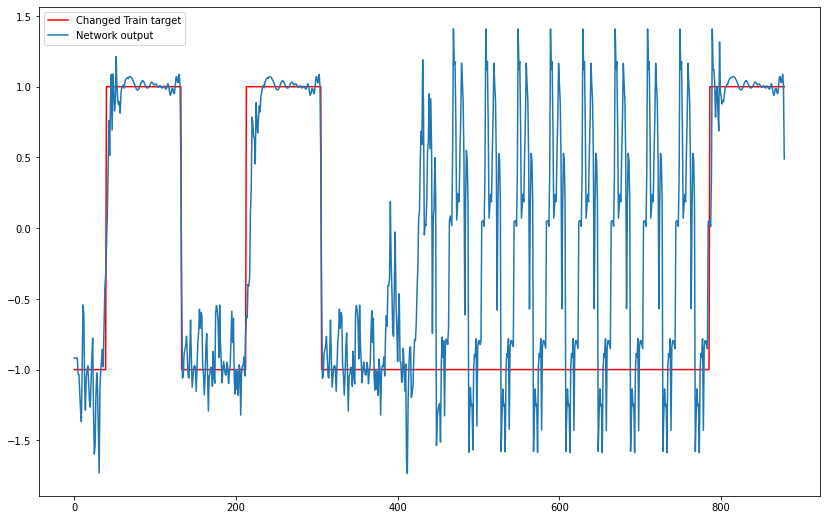

In [26]:
plt.figure(figsize=(14, 9))

plt.plot(T2, color='red')
plt.plot(output2)
plt.legend(['Changed Train target', 'Network output'])
plt.show()

In [27]:
output2[output2 >= 0] = 1.0
output2[output2 < 0] = -1.0

MSE = mean_squared_error(T2, output2)
print('MSE = {}'.format(MSE))
print('RMSE = {}'.format(np.sqrt(MSE)))

MSE = 0.9692832764505119
RMSE = 0.9845218516876667


### Задание №3

Построить и обучить нелинейную авторегрессионную сеть с внешними входами (Non-linearAutoRegressive network with eXogeneous inputs, NARX), которая будет выполнять аппроксимациютраектории динамической системы, также выполнить многошаговый прогноз значений системы.

Сформируем данные:

In [28]:
k = np.linspace(0, 10, (int)(10/0.01))

y = f(k)

In [29]:
inpt = u(k)[:, np.newaxis]
target = y

In [30]:
# data parameters:
delay = 3
trainSize = 700
testSize = 200
validSize = 97
shift=10

xTrain = k[:700]
xTest = k[700:900]
xValid = k[900:997]

yTrain = y[:700]
yTest = y[700:900]
yValid = y[900:997]

Создадим и обучим сеть:

In [2]:
narx = NARX(MLPRegressor(hidden_layer_sizes=(10, 10)), solver='lbfgs', max_iter=600,
                         auto_order=2, exog_order=[2], exog_delay=[delay])

NameError: name 'NARX' is not defined

In [33]:
narx.fit(inpt, target)

NameError: name 'narx' is not defined

Аппроксимируем систему:

In [34]:
output = narx.predict(input, target, step=1)

output[np.isnan(output)] = 0
MSE = mean_squared_error(target, output)
print('MSE = {}'.format(MSE))
print('RMSE = {}'.format(np.sqrt(MSE)))

NameError: name 'narx' is not defined

ValueError: x and y must have same first dimension, but have shapes (1000,) and (519,)

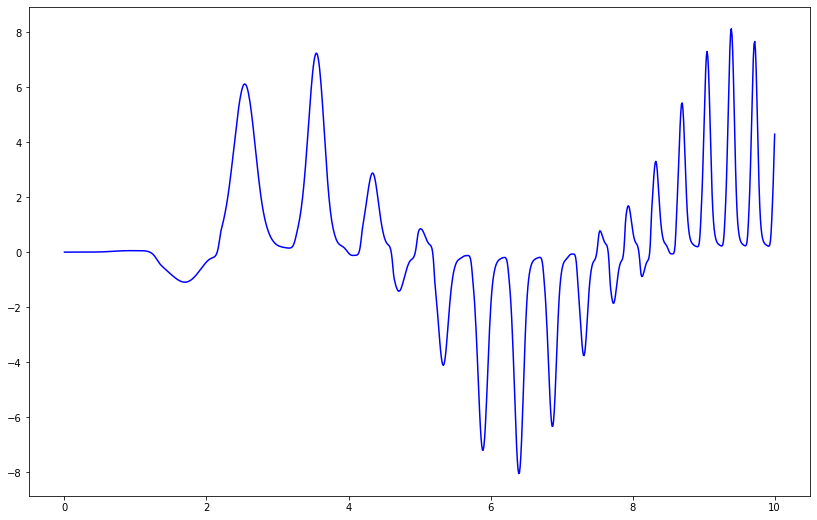

In [35]:
plt.figure(figsize=(14, 9))

plt.plot(k, y, color='blue')
plt.plot(k, output, color='green')
plt.legend(['Train data', 'Network output'])
plt.show()

Выполним многошаговый прогноз: обучим и рассчитаем выход сети для тестового подмножества.

In [36]:
narx = NARX(MLPRegressor(hidden_layer_sizes=(10, 10)), solver='lbfgs', max_iter=600,
                         auto_order=2, exog_order=[delay], exog_delay=[delay])
narx.fit(inpt, target)

NameError: name 'NARX' is not defined

In [37]:
inputTest = u(xTest)[:, np.newaxis]
targetTest = yTest
outputTest = narx.predict(inputTest, targetTest, step=3)

NameError: name 'narx' is not defined

In [38]:
outputTest[np.isnan(outputTest)] = 0
MSE = mean_squared_error(targetTest, outputTest)
print('MSE = {}'.format(MSE))
print('RMSE = {}'.format(np.sqrt(MSE)))

NameError: name 'outputTest' is not defined

NameError: name 'outputTest' is not defined

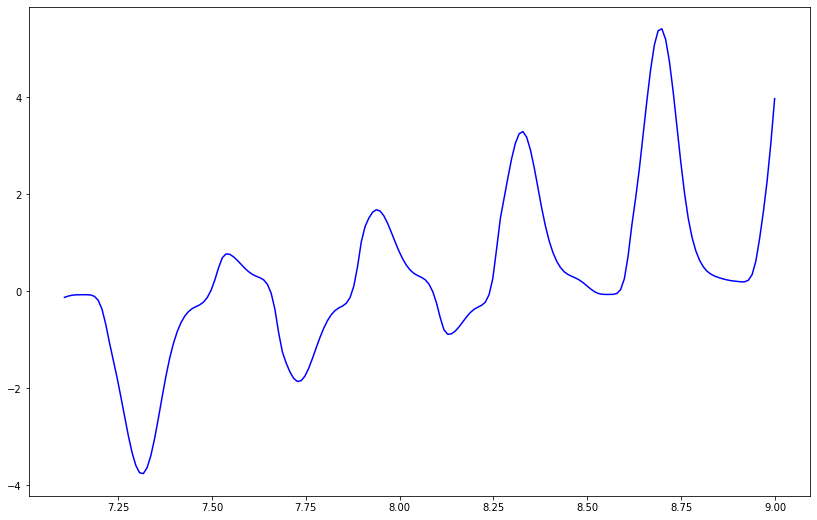

In [39]:
plt.figure(figsize=(14, 9))

plt.plot(xTest[shift:], yTest[shift:], color='blue')
plt.plot(xTest[shift:], outputTest[shift:])
plt.legend(['Test data', 'Network output'])
plt.show()